In [4]:
%matplotlib inline

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import lyrics
import visualization
import data_collection

# Analysis of Lyric Usage in Songs from Billboard Hot 100

In this notebook, I will perform some analysis on the lyrics of songs from the Billboard Hot 100. The dataset I will be using contains information about songs, chart performance and lyrics with sentiment analysis. The dataset has a lot of feature engineering done on it - there are features showing the words, used in the lyrics (both total and unique words), the number of words and analysis on different kinds of sentiment - joy, anger, sadness etc. The sentiment analysis is done via dictionaries, containing words for the different emotion. The score is calculated by checking how many words from the song lyrics are contained in the corresponding dictionary for each emotion feature.

In [7]:
hot_100 = pd.read_csv("data/hot_100_lyrics.csv").drop(columns = "Unnamed: 0")

In [8]:
hot_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18750 entries, 0 to 18749
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song              18750 non-null  object 
 1   main_artist       18750 non-null  object 
 2   peak_position     18750 non-null  int64  
 3   weeks_on_chart    18750 non-null  int64  
 4   date              18750 non-null  object 
 5   year              18750 non-null  int64  
 6   spotify_genre     18690 non-null  object 
 7   lyrics            18750 non-null  object 
 8   words             18750 non-null  object 
 9   word_count        18750 non-null  int64  
 10  all_words         18750 non-null  object 
 11  all_word_count    18750 non-null  int64  
 12  mtld              18750 non-null  float64
 13  sentiment_score   18750 non-null  float64
 14  emo_words         18750 non-null  object 
 15  emo_word_count    18750 non-null  int64  
 16  joy               18750 non-null  float6

## Correlations

First lets check the correlations between the chart popularity and sentiment scores. I will do this the exact same way I did for the spotify features.

In [10]:
hot_100.describe()

,peak_position,weeks_on_chart,year,word_count,all_word_count,mtld,sentiment_score,emo_word_count,joy,sadness,anger,disgust,trust,anticipation,fear,surprise,emo_score,happy,sorrow
count,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000
mean,43.952800,11.968693,1988.926240,69.922613,156.423093,36.464473,0.471293,77.295360,0.067393,0.026242,0.014727,0.011456,0.049481,0.026543,0.019311,0.011208,34.906979,0.128081,0.098279
std,29.901525,8.521825,18.935688,45.310092,96.337047,18.942436,0.787838,52.639437,0.051499,0.027480,0.018436,0.015388,0.040522,0.023710,0.022095,0.014256,24.494055,0.089237,0.070467
min,1.000000,1.000000,1958.000000,1.000000,1.000000,1.000000,-0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,5.000000,1972.000000,43.000000,92.000000,22.622285,-0.084400,42.000000,0.030099,0.008333,0.003054,0.001720,0.022576,0.010849,0.005211,0.003107,18.464250,0.066843,0.051207
50%,42.000000,11.000000,1987.000000,57.000000,130.000000,32.508840,0.964400,64.000000,0.054162,0.018210,0.009275,0.006740,0.038868,0.020374,0.012908,0.007472,28.484000,0.105488,0.082507
75%,70.000000,18.000000,2007.000000,79.000000,188.000000,46.437038,0.993800,98.000000,0.090700,0.034918,0.019896,0.015176,0.064443,0.034944,0.025704,0.014343,44.554250,0.164604,0.126623
max,100.000000,90.000000,2020.000000,390.000000,1325.000000,205.195789,1.000000,774.000000,0.483700,0.327168,0.298526,0.263071,0.559818,0.375000,0.354896,0.284482,416.824000,0.930187,1.002444


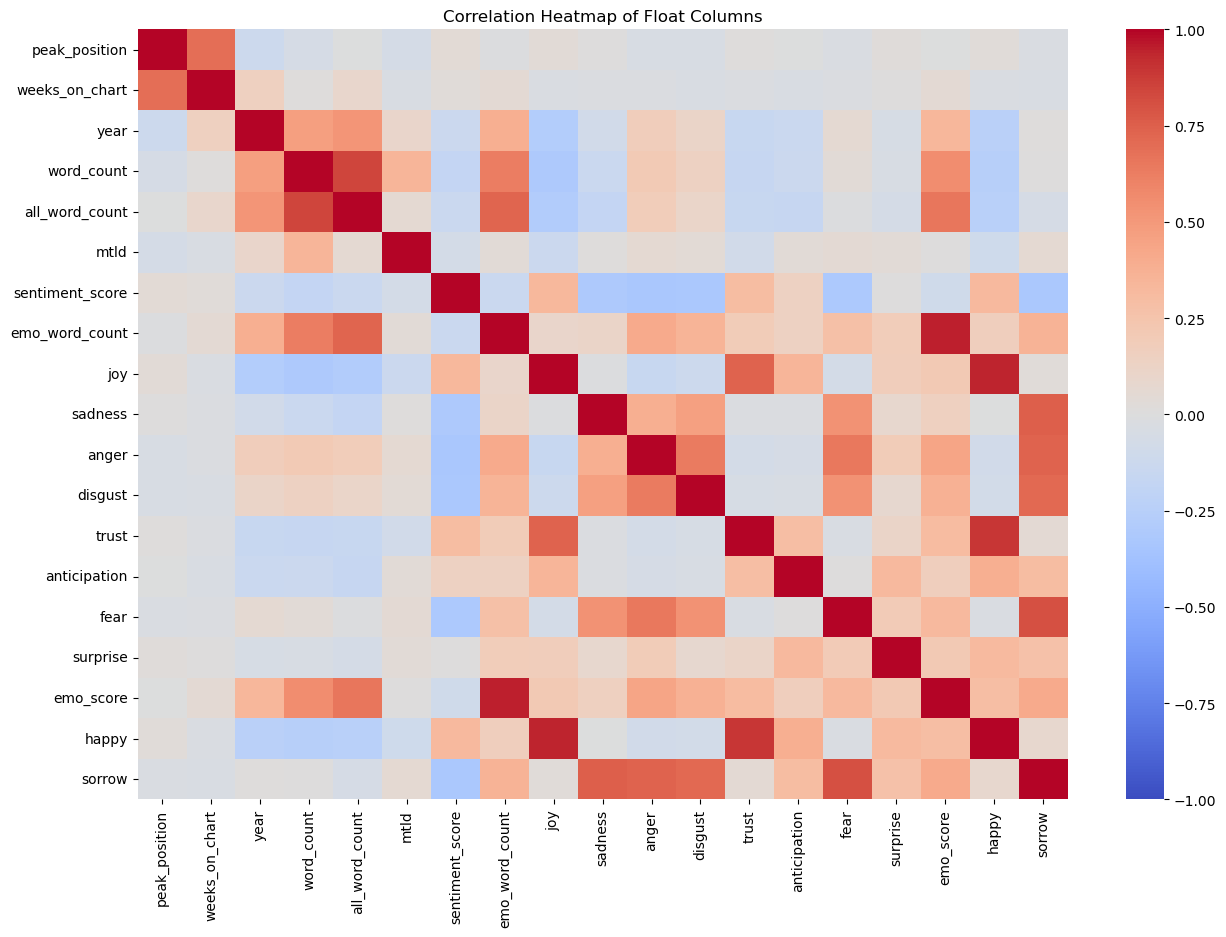

In [11]:
#Get the numerical columns
hot_100_numerical = hot_100.select_dtypes(include = ['float', 'int'])
hot_100_numerical.peak_position *= -1
correlation_matrix = hot_100_numerical.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Float Columns')
plt.show()

In [12]:
hot_100_numerical.corr()

,peak_position,weeks_on_chart,year,word_count,all_word_count,mtld,sentiment_score,emo_word_count,joy,sadness,anger,disgust,trust,anticipation,fear,surprise,emo_score,happy,sorrow
peak_position,1.000000,0.693155,-0.117354,-0.059564,-0.006737,-0.066896,0.039554,-0.013927,0.033722,0.001048,-0.039822,-0.040324,0.011238,-0.001410,-0.027713,0.016099,-0.005946,0.027136,-0.027980
weeks_on_chart,0.693155,1.000000,0.153604,0.013226,0.092864,-0.031972,0.027902,0.053621,-0.030857,-0.019727,-0.018643,-0.032257,-0.023339,-0.032522,-0.019927,0.004211,0.051533,-0.027733,-0.036806
year,-0.117354,0.153604,1.000000,0.469605,0.515952,0.099370,-0.126132,0.386585,-0.277260,-0.089043,0.179144,0.115246,-0.153844,-0.134070,0.061229,-0.051540,0.341624,-0.238100,0.011400
word_count,-0.059564,0.013226,0.469605,1.000000,0.851174,0.347389,-0.172108,0.630052,-0.307144,-0.135570,0.209660,0.145971,-0.158621,-0.127872,0.038063,-0.042541,0.561673,-0.256079,0.002771
all_word_count,-0.006737,0.092864,0.515952,0.851174,1.000000,0.055135,-0.133280,0.728047,-0.287665,-0.178139,0.181265,0.108591,-0.155218,-0.163500,-0.010248,-0.069747,0.663532,-0.247638,-0.056557
mtld,-0.066896,-0.031972,0.099370,0.347389,0.055135,1.000000,-0.070675,0.035395,-0.131655,0.010987,0.058921,0.044944,-0.086081,0.033043,0.052886,0.036959,0.004348,-0.109163,0.057215
sentiment_score,0.039554,0.027902,-0.126132,-0.172108,-0.133280,-0.070675,1.000000,-0.134406,0.331327,-0.309375,-0.335357,-0.323245,0.296897,0.147856,-0.315063,0.006071,-0.095383,0.326999,-0.328012
emo_word_count,-0.013927,0.053621,0.386585,0.630052,0.728047,0.035395,-0.134406,1.000000,0.094565,0.115551,0.406523,0.353840,0.192457,0.147365,0.276324,0.185201,0.951463,0.171554,0.364915
joy,0.033722,-0.030857,-0.277260,-0.307144,-0.287665,-0.131655,0.331327,0.094565,1.000000,-0.010049,-0.152599,-0.118532,0.736067,0.350972,-0.077074,0.177832,0.211936,0.939756,0.024199
sadness,0.001048,-0.019727,-0.089043,-0.135570,-0.178139,0.010987,-0.309375,0.115551,-0.010049,1.000000,0.388805,0.461719,-0.021226,-0.021069,0.536126,0.085559,0.150772,-0.001769,0.753529


### Observations:
* The chart performance doesn't have a noticable correlation with the features individually.
* Sadness, sorrow, anger and fear are positively correlated.
* happiness, trust and joy have very strong correlations with each other, probably because the dictionaries for these emotions are mostly the same.

## Word analysis

My next goal is to analyze which words are the most widely used in the Billboard Hot 100.  I want to be able to see the most popular words overall and the most popular words for a specific genre.

I created a functions, called `get_common_words` and `plot_common_words` for this purpose. They get a dictionary of the most used words and then plot them in a **wordcloud**.

Before that, I will need to convert the `all_words`, `words` and `nouns_adjectives` columns to lists, because they are read as string objects.

In [14]:
hot_100.all_words = hot_100.all_words.apply(ast.literal_eval)
hot_100.words = hot_100.words.apply(ast.literal_eval)
hot_100.nouns_adjectives = hot_100.nouns_adjectives.apply(ast.literal_eval)

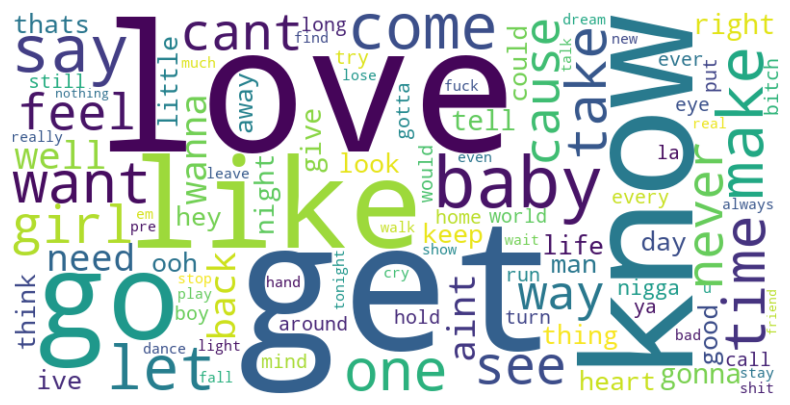

In [15]:
#Plot a wordcloud of most common words for the whole dataset
lyrics.plot_common_words(hot_100)

Of course words like **baby**, **love** and **like** are the most used, as most songs are about love. Other words like **say**, **get**, **go**, **know** etc. also appear quite often. You could make an argument that these words are also in some way stopwords, as they don't really give us any valuable information for what are the lyrics talking about.

Lets do something different. I created a new column that contains only the adjectives and nouns of the lyrics for this exact reason. They will give more information about what the most popular words are about.

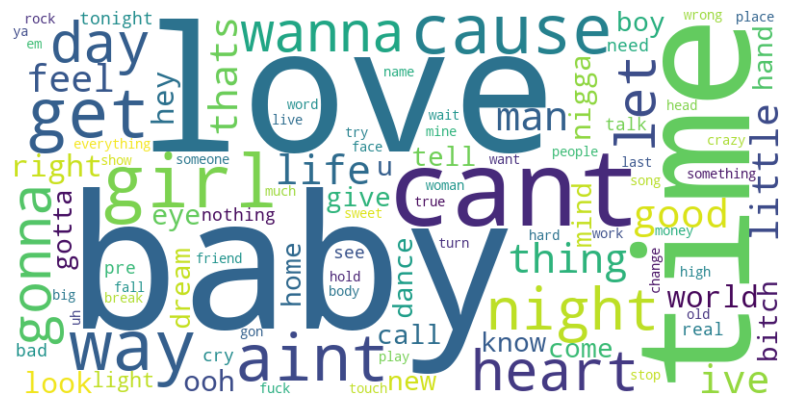

In [17]:
lyrics.plot_common_words(hot_100, col = 'nouns_adjectives')

This paints a similar picture, but with a little differences. The word cloud still contains some verbs, even though I filtered them out, but they are less in total.

To get the word clouds for specific genres, I need to again expand the dataset to contain a row for every genre, like I did for the spotify features.

In [19]:
hot_100_expanded = hot_100.dropna(subset = 'spotify_genre').copy()
hot_100_expanded.spotify_genre = hot_100_expanded.spotify_genre.apply(ast.literal_eval)
hot_100_expanded = hot_100_expanded.explode('spotify_genre')

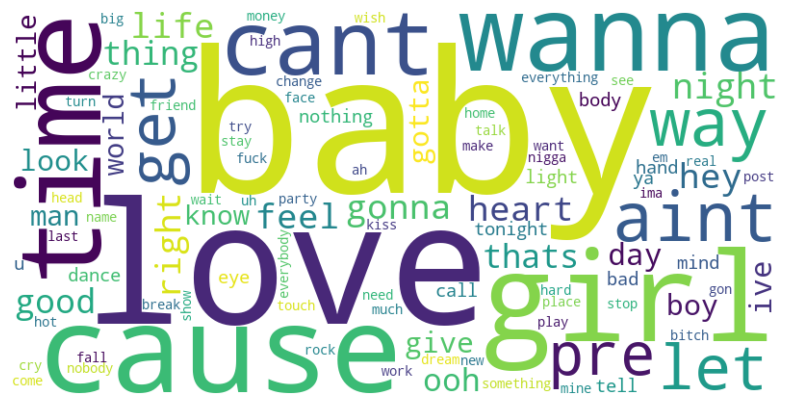

In [20]:
lyrics.plot_common_words(hot_100_expanded, genre = 'pop', col = 'nouns_adjectives')

For pop, the most common words are similar to the ones for all genres - love, girl, baby, time etc.

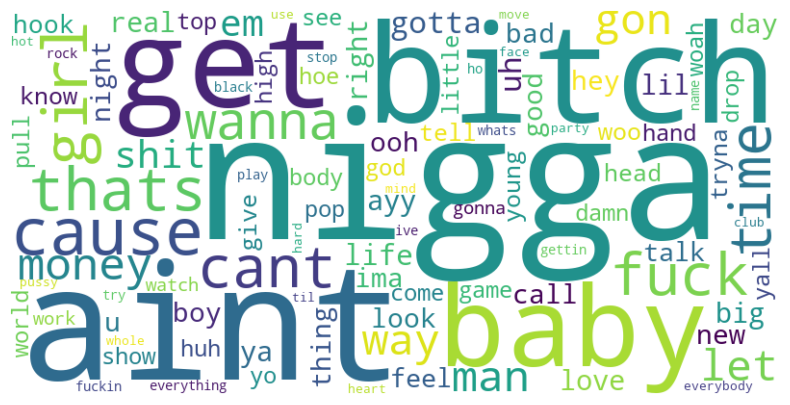

In [22]:
lyrics.plot_common_words(hot_100_expanded, genre = 'rap', col = 'nouns_adjectives')

For rap songs the most popular words are mostly slurs.

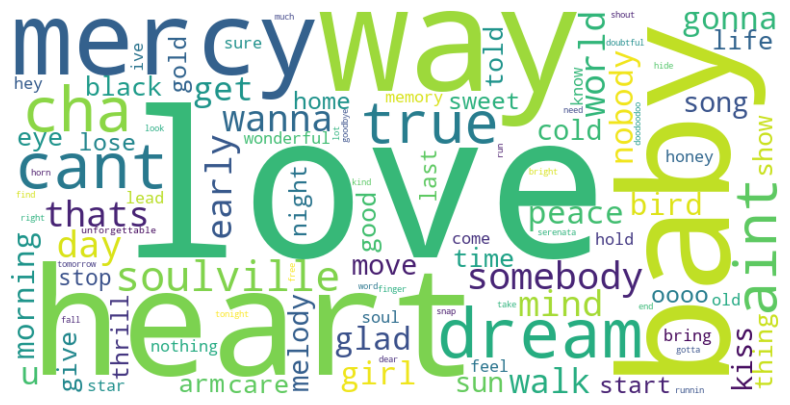

In [24]:
lyrics.plot_common_words(hot_100_expanded, genre = 'jazz', col = 'nouns_adjectives')

For jazz songs the most popular words are again **baby** and **love**, but we see some new words emerging, like **heart**, **mercy** and **dream**.

### Most Popular Bag of Words

Now lets count the most popular pairs of 2 and 3 words. To do so I will create a new column that contains lyrics, by joining the `all_words` values into a single string. I already have a column for lyrics, however by creating a new one this way, I will have effectively removed the stopwords.

In [26]:
hot_100['clean_lyrics'] = hot_100.all_words.apply(lambda x: " ".join(x))

In [27]:
hot_100.clean_lyrics

0        fever dream high quiet night know caught right...
1        get fast car want ticket anywhere maybe make d...
2        rockin around christmas tree christmas party h...
3        want lot christmas one thing need care present...
4        dingdongding dingdongding dingdongding holly j...
                               ...                        
18745    beautiful delilah sweet apple pie always get s...
18746    someone care someone share lonely hour moment ...
18747    doo doo doo doo well go dance night oooh every...
18748    ames brother miscellaneous melodie damour melo...
18749    voice bring every hope spring thats judy judy ...
Name: clean_lyrics, Length: 18750, dtype: object

Now that I have the clean lyrics, I need to create a list that contains all the words used in the dataset and then use `CountVectorizer` from `sklearn` to apply the Bag of Words technique.

In [29]:
full_words = ' '.join(hot_100['clean_lyrics'])

vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the corpus
X = vectorizer.fit_transform([full_words])

# Convert to a DataFrame
ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum the occurrences of each n-gram
ngram_counts = ngram_counts.sum(axis=0)

# Convert Series to dictionary for word cloud
ngram_dict = ngram_counts.to_dict()

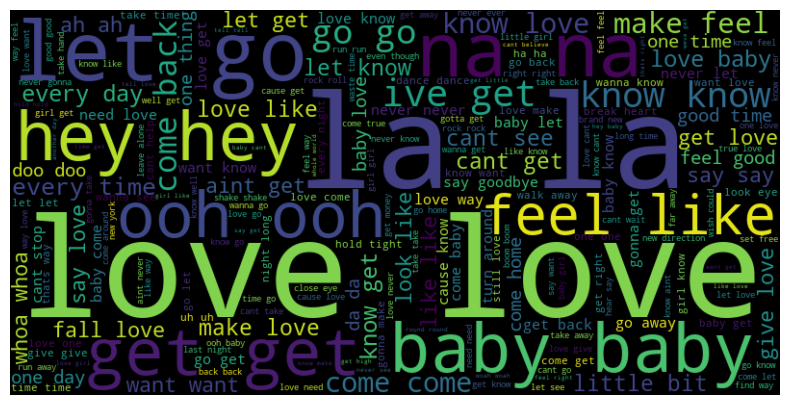

In [30]:
#Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(ngram_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The result is mostly nonsensical combinations, like **la la**, **baby baby**, **ooh ooh**, **love love** - basically repeating a word two times. Some noticeable combinations are **let go**, **feel like**, **make feel**, **make love**. Keep in mind that stopwords are removed and the words are lemmatized, so most of these word combinations have pronouns and/or prepositions between them.

Lets also see what are the most common combinations of three and four words:

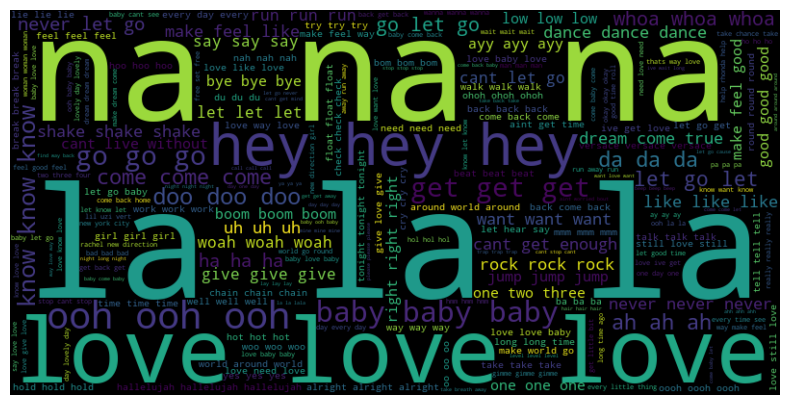

In [32]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
X = vectorizer.fit_transform([full_words])

ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
ngram_counts = ngram_counts.sum(axis=0)
ngram_dict = ngram_counts.to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(ngram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The most popular are again combinations of the same word three times - **na na na **, **la la la**, **love love love**. Actually, most of the combinations are like this here, which leads me to believe that this will also be the case for combinations of four words.

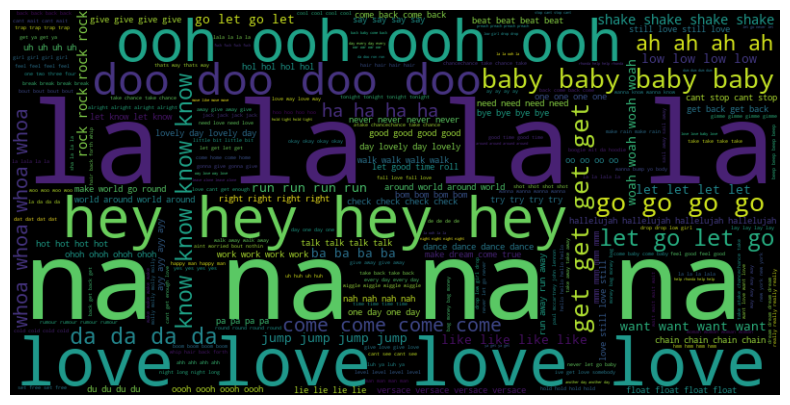

In [34]:
vectorizer = CountVectorizer(ngram_range=(4, 4))
X = vectorizer.fit_transform([full_words])

ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
ngram_counts = ngram_counts.sum(axis=0)
ngram_dict = ngram_counts.to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(ngram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Highest charting word

Lets now try to see which word in songs has the highest average placement. To do that I will expand the dataset to contain a row for all unique words, used in each song. This leads to a dataset, that contains over 1.3 million rows

In [36]:
hot_100_exploded_words = hot_100.explode('words')

In [37]:
hot_100_exploded_words

,song,main_artist,peak_position,weeks_on_chart,date,year,spotify_genre,lyrics,words,word_count,...,disgust,trust,anticipation,fear,surprise,emo_score,happy,sorrow,nouns_adjectives,clean_lyrics
0,Cruel Summer,taylor swift,1,54,2024-05-25,2019,"['dance pop', 'pop', 'post-teen pop']",yeah yeah yeah yeah\n\n\nfever dream high in t...,rule,93,...,0.034701,0.040000,0.025705,0.041656,0.010017,71.534,0.116477,0.180344,"[high, quiet, night, want, bad, bad, boy, shin...",fever dream high quiet night know caught right...
0,Cruel Summer,taylor swift,1,54,2024-05-25,2019,"['dance pop', 'pop', 'post-teen pop']",yeah yeah yeah yeah\n\n\nfever dream high in t...,keep,93,...,0.034701,0.040000,0.025705,0.041656,0.010017,71.534,0.116477,0.180344,"[high, quiet, night, want, bad, bad, boy, shin...",fever dream high quiet night know caught right...
0,Cruel Summer,taylor swift,1,54,2024-05-25,2019,"['dance pop', 'pop', 'post-teen pop']",yeah yeah yeah yeah\n\n\nfever dream high in t...,devil,93,...,0.034701,0.040000,0.025705,0.041656,0.010017,71.534,0.116477,0.180344,"[high, quiet, night, want, bad, bad, boy, shin...",fever dream high quiet night know caught right...
0,Cruel Summer,taylor swift,1,54,2024-05-25,2019,"['dance pop', 'pop', 'post-teen pop']",yeah yeah yeah yeah\n\n\nfever dream high in t...,window,93,...,0.034701,0.040000,0.025705,0.041656,0.010017,71.534,0.116477,0.180344,"[high, quiet, night, want, bad, bad, boy, shin...",fever dream high quiet night know caught right...
0,Cruel Summer,taylor swift,1,54,2024-05-25,2019,"['dance pop', 'pop', 'post-teen pop']",yeah yeah yeah yeah\n\n\nfever dream high in t...,ooh,93,...,0.034701,0.040000,0.025705,0.041656,0.010017,71.534,0.116477,0.180344,"[high, quiet, night, want, bad, bad, boy, shin...",fever dream high quiet night know caught right...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18749,Judy,frankie vaughan,100,1,1958-08-04,1958,['rock-and-roll'],if her voice can bring\nevery hope of spring\n...,tell,52,...,0.007092,0.044815,0.026677,0.030138,0.036169,15.911,0.112354,0.132431,"[voice, bring, hope, spring, thats, judy, eye,...",voice bring every hope spring thats judy judy ...
18749,Judy,frankie vaughan,100,1,1958-08-04,1958,['rock-and-roll'],if her voice can bring\nevery hope of spring\n...,every,52,...,0.007092,0.044815,0.026677,0.030138,0.036169,15.911,0.112354,0.132431,"[voice, bring, hope, spring, thats, judy, eye,...",voice bring every hope spring thats judy judy ...
18749,Judy,frankie vaughan,100,1,1958-08-04,1958,['rock-and-roll'],if her voice can bring\nevery hope of spring\n...,drawl,52,...,0.007092,0.044815,0.026677,0.030138,0.036169,15.911,0.112354,0.132431,"[voice, bring, hope, spring, thats, judy, eye,...",voice bring every hope spring thats judy judy ...
18749,Judy,frankie vaughan,100,1,1958-08-04,1958,['rock-and-roll'],if her voice can bring\nevery hope of spring\n...,shell,52,...,0.007092,0.044815,0.026677,0.030138,0.036169,15.911,0.112354,0.132431,"[voice, bring, hope, spring, thats, judy, eye,...",voice bring every hope spring thats judy judy ...


Next, I will group the dataframe by the unique words and get the mean of the peak position. This will result in a series, that show the average peak position of songs, that contain each of the unique words. Before that I will filter out words that are met less than 100 songs in the dataset.

I have done these operations in a function, called `word_avg_position`, which allows me to get either the lowest or highest average position for words that are met more than **n** songs.

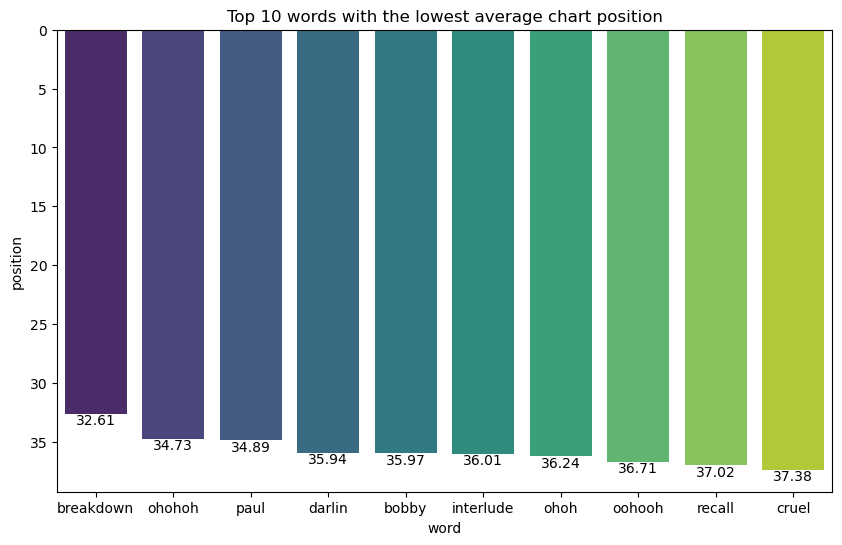

In [39]:
lyrics.word_avg_position(hot_100_exploded_words)

We get some proper nouns - **paul** and **bobby** and some different types of the exclamation **oh**. The only interesting words here are **breakdown**, **darlin**, **interlude**, **recall** and **cruel**.

What about the lowest charting words?

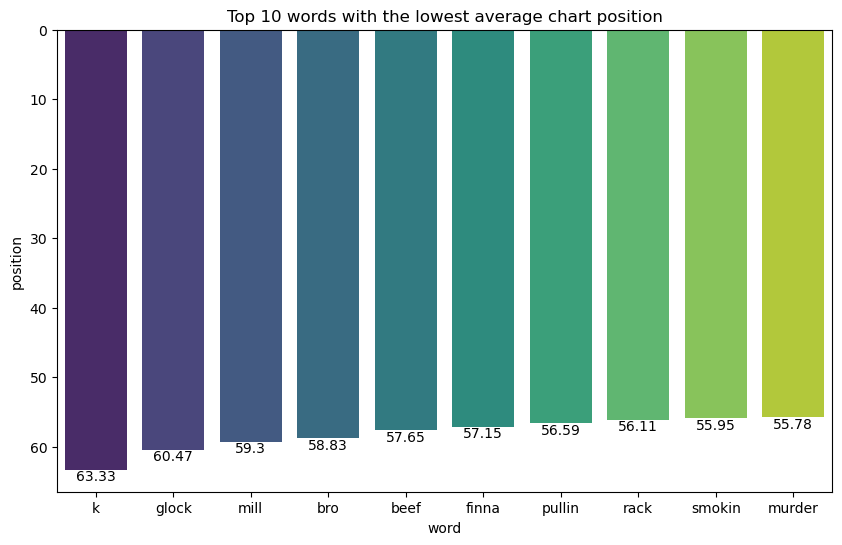

In [44]:
lyrics.word_avg_position(hot_100_exploded_words, lowest_positions = False)

the letter **k** for some reason has the lowest average position. Some of the following words are associated with **bad** things - **glock**, **murder**, **beef**, **murder**. These are mostly words, used in the hip hop genre.

Lets also check the results for words with higher frequencies.

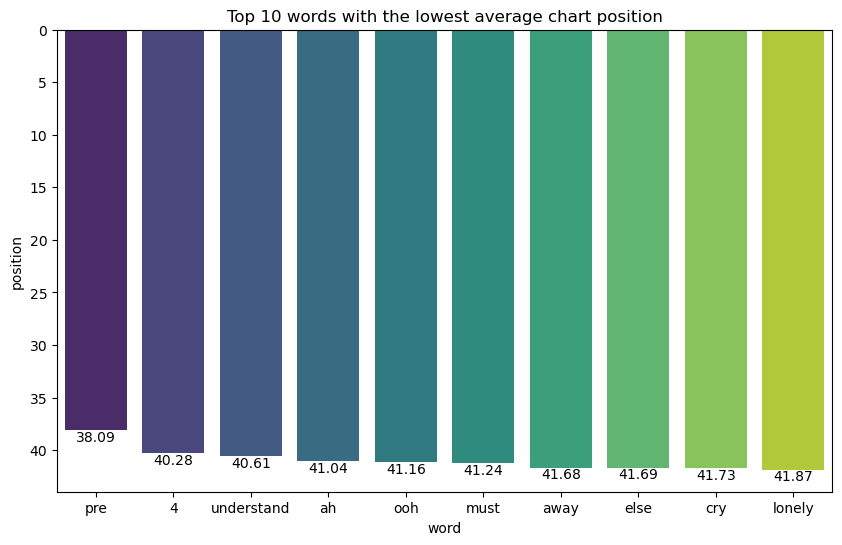

In [56]:
lyrics.word_avg_position(hot_100_exploded_words, n = 1000)

The average position falls, because of the bigger sample. The highest charting word is now **pre**, which still is not a very informational word, but the rest are mostly words that make sense - **understand**, **awat**, **cry**, **lonely**. Words with negative sentiment. 

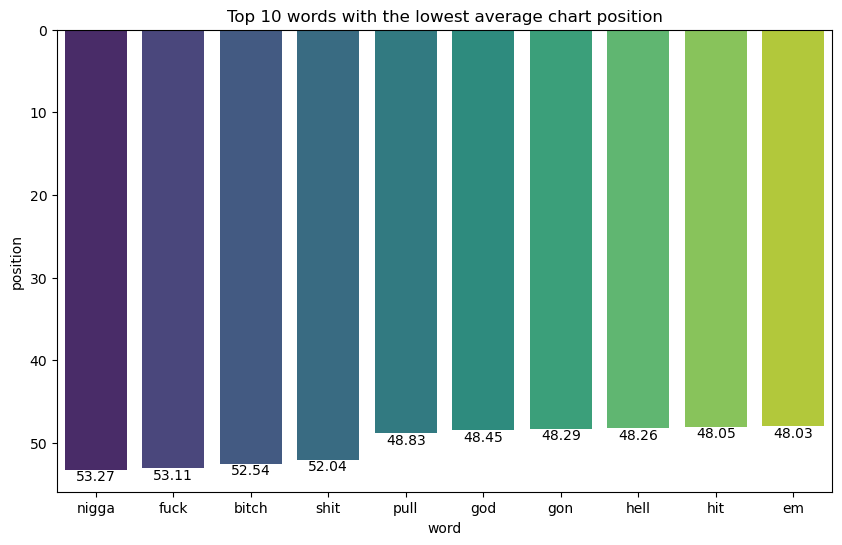

In [50]:
lyrics.word_avg_position(hot_100_exploded_words, n = 1000, lowest_positions = False)

Here the average position rises, because of the bigger sample, however the top 10 worst performing words are filled with even more slurs.